## Fitting Models to Data: An Old Example from EXOSAT

Our first example uses very old data which is much simpler than more modern observations and so can be used to better illustrate the basics of XSPEC analysis. The 6s X-ray pulsar 1E1048.1-5937 was observed by EXOSAT in June 1985 for 20 ks. In this example, we'll conduct a general investigation of the spectrum from the Medium Energy (ME) instrument, i.e. follow the same sort of steps as the original investigators (Seward, Charles & Smale, 1986). The ME spectrum and corresponding response matrix were obtained from the HEASARC and are available from https://heasarc.gsfc.nasa.gov/docs/xanadu/xspec/walkthrough.tar.gz

This version of the notebook does all plotting through matplotlib.

We start with some standard imports.

In [1]:
# uncomment the line below to make matplotlib plots dynamic
#%matplotlib notebook
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
# this ensures that all C output is redirected to the Jupyter output box
%load_ext wurlitzer

from xspec import *

Now read a spectrum into a Spectrum object called s1. The file is stored in a sub-directory data so first cd to it.

In [2]:
%cd data
s1 = Spectrum("s54405.pha")

/Users/karnaud/Jupyter-notebooks/data

1 spectrum  in use
 
Spectral Data File: s54405.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.783e+00 +/- 1.367e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-125
  Telescope: EXOSAT Instrument: ME  Channel Type: PHA
  Exposure Time: 2.358e+04 sec
 Using fit statistic: chi
 Using Response (RMF) File            s54405.rsp for Source 1



Spectrum tells the program to read the data as well as the response file that is named in the header of the data file. 

One of the first things most users will want to do at this stage - even before fitting models - is to look at their data. There are more than 50 different things that can be plotted, all related in some way to the data, the model, the fit and the instrument. To see them, type: 

In [3]:
Plot("?")

plot data/models/fits etc
    Syntax: plot commands:
	background     chain          chisq          contour        counts         
	integprob      data           delchi         dem            emodel         
	eemodel        efficiency     eqw            eufspec        eeufspec       
	foldmodel      goodness       icounts        insensitivity  lcounts        
	ldata          margin         model          ratio          residuals      
	sensitivity    sum            ufspec         
    Multi-panel plots are created by entering multiple options e.g. data chisq



The most fundamental is the data plotted against instrument channel (data); next most fundamental, and more informative, is the data plotted against channel energy. To do this: 


In [4]:
Plot.device = "/null"
Plot.xAxis="keV"
Plot("data")
energies = Plot.x()
edeltas = Plot.xErr()
rates = Plot.y()
errors = Plot.yErr()
labels = Plot.labels()

<ErrorbarContainer object of 3 artists>

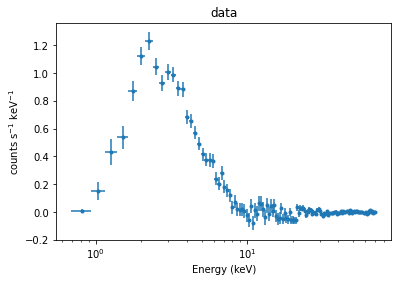

In [5]:
plt.xscale('log')
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.title(labels[2])
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.')

We are now ready to fit the data with a model. Models in XSPEC are specified using the model command, followed by an algebraic expression of a combination of model components. There are two basic kinds of model components: additive and multiplicative. Additive components represent X-Ray sources of different kinds (e.g., a bremsstrahlung continuum) and, after being convolved with the instrument response, prescribe the number of counts per energy bin. Multiplicative components represent phenomena that modify the observed X-Radiation (e.g. reddening or an absorption edge). They apply an energy-dependent multiplicative factor to the source radiation before the result is convolved with the instrumental response.

More generally, XSPEC allows three types of modifying components: convolutions and mixing models in addition to the multiplicative type. Since there must be a source, there must be least one additive component in a model, but there is no restriction on the number of modifying components.

Given the quality of our data, as shown by the plot, we'll choose an absorbed power law. To set it up define a Model object called m1.

In [6]:
m1 = Model("phabs(powerlaw)")


Model phabs<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   3    2   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              4.878354e+08     using 125 bins.

Test statistic : Chi-Squared              4.878354e+08     using 125 bins.
 Null hypothesis probability of 0.000000e+00 with 122 degrees of freedom
 Current data and model not fit yet.


The current statistic is $\chi^2$ and is huge for the initial, default values - mostly because the power law normalization is two orders of magnitude too large. This is easily fixed using the renorm method.

In [7]:
Fit.renorm()


Fit statistic  : Chi-Squared                  845.91     using 125 bins.

Test statistic : Chi-Squared                  845.91     using 125 bins.
 Null hypothesis probability of 1.09e-108 with 122 degrees of freedom
 Current data and model not fit yet.


We are not quite ready to fit the data (and obtain a better $\chi^2$), because not all of the 125 PHA bins should be included in the fitting: some are below the lower discriminator of the instrument and therefore do not contain valid data; some have imperfect background subtraction at the margins of the pass band; and some may not contain enough counts for $\chi^2$ to be strictly meaningful. To find out which channels to discard (ignore in XSPEC terminology), consult mission-specific documentation that will include information about discriminator settings, background subtraction problems and other issues. For the mature missions in the HEASARC archives, this information already has been encoded in the headers of the spectral files as a list of bad channels. To remove the bad channels from the spectrum that we read into s:

In [8]:
AllData.ignore("bad")


ignore:    40 channels ignored from  source number 1
Fit statistic  : Chi-Squared                  793.46     using 85 bins.

Test statistic : Chi-Squared                  793.46     using 85 bins.
 Null hypothesis probability of 5.97e-117 with 82 degrees of freedom
 Current data and model not fit yet.



Note that PyXspec doesn't allow us to ignore "bad" channels for individual spectra but does it for all loaded spectra. AllData is a special object which allows operations on all current spectra. Now plot again:

In [9]:
Plot("ldata chi")
energies = Plot.x()
edeltas = Plot.xErr()
rates = Plot.y(1,1)
errors = Plot.yErr(1,1)
foldedmodel = Plot.model()
dataLabels = Plot.labels(1)
chiLabels = Plot.labels(2)
# note that for matplotlib step plots we need an x-axis array which includes the start and end value for each
# bin and the y-axis has to be the same size with an extra value added equal to the value of the last bin
nE = len(energies)
stepenergies = list()
for i in range(nE):
    stepenergies.append(energies[i] - edeltas[i])
stepenergies.append(energies[-1]+edeltas[-1])
foldedmodel.append(foldedmodel[-1])
chi = Plot.y(1,2)
chi.append(chi[-1])

***Warning: Fit is not current.


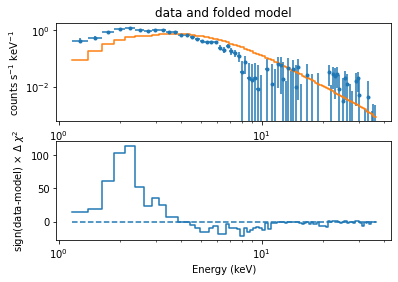

In [10]:
plt.subplot(211)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(dataLabels[1])
plt.title(dataLabels[2])
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.')
plt.step(stepenergies,foldedmodel,where='post')
plt.subplot(212)
plt.xscale('log')
plt.xlabel(chiLabels[0])
plt.ylabel(chiLabels[1])
plt.step(stepenergies,chi,where='post')
plt.hlines(0.0,stepenergies[0],stepenergies[-1],linestyles='dashed')

We get a warning that the fit is not current because no fit has been performed yet. 

Giving two options for the Plot command generates a plot with vertically stacked windows. Up to six options can be given to the Plot command at a time. Forty channels were rejected because they were flagged as bad - but do we need to ignore any more? This figure shows the result of plotting the data and the model (in the upper window) and the contributions to $\chi^2$ (in the lower window). We see that above about 15 keV the S/N becomes small. We also see, comparing with the earlier figure, which bad channels were ignored. Although visual inspection is not the most rigorous method for deciding which channels to ignore (more on this subject later), it's good enough for now, and will at least prevent us from getting grossly misleading results from the fitting. To ignore energies above 15 keV: 

In [11]:
s1.ignore("15.0-**")

    78 channels (48-125) ignored in spectrum #     1

Fit statistic  : Chi-Squared                  715.30     using 45 bins.

Test statistic : Chi-Squared                  715.30     using 45 bins.
 Null hypothesis probability of 2.42e-123 with 42 degrees of freedom
 Current data and model not fit yet.



Note that ignore (and notice) interpret integers as channel numbers and real numbers as energies. The double star is a special indicator which just means the extreme value in the spectrum.

We are now ready to fit the data. Fitting is initiated by the command Fit.perform(). As the fit proceeds, the screen displays the status of the fit for each iteration until either the fit converges to the minimum $\chi^2$, or the maximum number of iterations is exceeded. The maximum number of iterations is Fit.nIterations.

In [12]:
print(Fit.nIterations)

10


In [13]:
Fit.perform()

                                   Parameters
Chi-Squared  |beta|/N    Lvl          1:nH    2:PhoIndex        3:norm
450.421      150.593      -3     0.0916817       1.61266    0.00388600
412.275      63000.6      -3      0.283518       2.30662    0.00911916
53.9571      27976.3      -4      0.529631       2.14207     0.0121535
43.8301      4648.87      -5      0.565375       2.23873     0.0130851
43.8179      125.675      -6      0.552335       2.23611     0.0130313
43.8179      0.622244     -7      0.551351       2.23578     0.0130239
 Variances and Principal Axes
                 1        2        3  
 4.7830E-08| -0.0025  -0.0151   0.9999  
 2.3114E-03|  0.3929  -0.9195  -0.0129  
 9.0741E-02|  0.9196   0.3928   0.0082  
----------------------------------------

  Covariance Matrix
        1           2           3   
   7.709e-02   3.194e-02   6.736e-04
   3.194e-02   1.595e-02   3.201e-04
   6.736e-04   3.201e-04   6.553e-06
------------------------------------

Model phabs<1>*po

There is a fair amount of information here so we will unpack it a bit at a time. One line is written out after each fit iteration. The columns labeled Chi-Squared and Parameters are obvious. The other two provide additional information on fit convergence. At each step in the fit a numerical derivative of the statistic with respect to the parameters is calculated. We call the vector of these derivatives beta. At the best-fit the norm of beta should be zero so we write out |beta| divided by the number of parameters as a check. The actual default convergence criterion is when the fit statistic does not change significantly between iterations so it is possible for the fit to end while |beta| is still significantly different from zero. The |beta|/N column helps us spot this case. The Lvl column also indicates how the fit is converging and should generally decrease. Note that on the first iteration only the powerlaw norm is varied. While not necessary this simple model, for more complicated models only varying the norms on the first iteration helps the fit proper get started in a reasonable region of parameter space.

At the end of the fit PyXspec writes out the Variances and Principal Axes and Covariance Matrix sections. These are both based on the second derivatives of the statistic with respect to the parameters. Generally, the larger these second derivatives, the better determined the parameter (think of the case of a parabola in 1-D). The Covariance Matrix is the inverse of the matrix of second derivatives. The Variances and Principal Axes section is based on an eigenvector decomposition of the matrix of second derivatives and indicates which parameters are correlated. We can see in this case that the first eigenvector depends almost entirely on the powerlaw norm while the other two are combinations of the nH and powerlaw PhoIndex. This tells us that the norm is independent but the other two parameters are correlated.

The next section shows the best-fit parameters and error estimates. The latter are just the square roots of the diagonal elements of the covariance matrix so implicitly assume that the parameter space is multidimensional Gaussian with all parameters independent. We already know in this case that the parameters are not independent so these error estimates should only be considered guidelines to help us determine the true errors later.

The final section shows the statistic values at the end of the fit. PyXspec defines a fit statistic, used to determine the best-fit parameters and errors, and test statistic, used to decide whether this model and parameters provide a good fit to the data. By default, both statistics are $\chi^2$. When the test statistic is $\chi^2$ we can also calculate the null hypothesis probability. This is the probability of getting a value of $\chi^2$ as large or larger than observed if the model is correct. If this probability is small then the model is not a good fit. The null hypothesis probability can be calculated analytically for $\chi^2$ but not for some other test statistics so PyXspec provides another way of determining the meaning of the statistic value. The Fit.goodness() method performs simulations of the data based on the current model and parameters and compares the statistic values calculated with that for the real data. If the observed statistic is larger than the values for the simulated data this implies that the real data do not come from the model. To see how this works we will use the command for this case (where it is not necessary):

In [14]:
Fit.goodness(1000)

62.80% of realizations are < best test statistic 43.82  (nosim)  (fit)


62.8

Approximately 60% of the simulations give a statistic value less than that observed, consistent with this being a good fit. We can plot a histogram of the $\chi^2$ values from the simulations with the observed value shown by the vertical dotted line. 

In [15]:
Plot("goodness")
statvals = Plot.x()
statdeltas = Plot.xErr()
probvals = Plot.y()
labels = Plot.labels()
nBins = len(statvals)
statstepvals = list()
for i in range(nBins):
    statstepvals.append(statvals[i] - statdeltas[i])
statstepvals.append(statvals[-1]+statdeltas[-1])
probvals.append(probvals[-1])
maxprob = 0
for i in range(nBins):
    if probvals[i] > maxprob: maxprob = probvals[i]

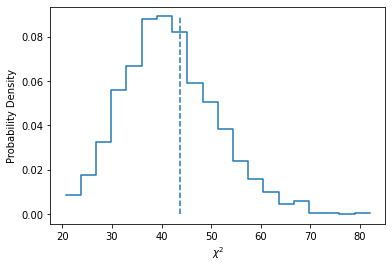

In [16]:
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.step(statstepvals,probvals,where='post')
plt.vlines(Fit.testStatistic,0.0,maxprob,linestyles='dashed')

So the statistic implies the fit is good but it is still always a good idea to look at the data and residuals to check for any systematic differences that may not be caught by the test. 

In [17]:
Plot("data resid")
energies = Plot.x()
edeltas = Plot.xErr()
rates = Plot.y(1,1)
errors = Plot.yErr(1,1)
foldedmodel = Plot.model()
dataLabels = Plot.labels(1)
residLabels = Plot.labels(2)
# note that for matplotlib step plots we need an x-axis array which includes the start and end value for each
# bin and the y-axis has to be the same size with an extra value added equal to the value of the last bin
nE = len(energies)
stepenergies = list()
for i in range(nE):
    stepenergies.append(energies[i] - edeltas[i])
stepenergies.append(energies[-1]+edeltas[-1])
foldedmodel.append(foldedmodel[-1])
resid = Plot.y(1,2)
residerr = Plot.yErr(1,2)

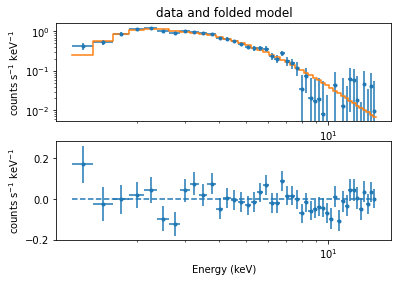

In [18]:
plt.subplot(211)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(dataLabels[1])
plt.title(dataLabels[2])
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.')
plt.step(stepenergies,foldedmodel,where='post')
plt.subplot(212)
plt.xscale('log')
plt.xlabel(residLabels[0])
plt.ylabel(residLabels[1])
plt.errorbar(energies,resid,xerr=edeltas,yerr=residerr,fmt='.')
plt.hlines(0.0,stepenergies[0],stepenergies[-1],linestyles='dashed')

Now that we think we have the correct model we need to determine how well the parameters are determined. The screen output at the end of the fit shows the best-fitting parameter values, as well as approximations to their errors. These errors should be regarded as indications of the uncertainties in the parameters and should not be quoted in publications. The true errors, i.e. the confidence ranges, are obtained using the Fit.error() command. We want to run error on all three parameters which is an intrinsically parallel operation so we can use PyXspec's support for multiple cores and run the error estimations in parallel:

In [19]:
Xset.parallel.error = 3
Fit.error("1-3")

 Parameter   Confidence Range (2.706)
     1     0.109538      1.03334    (-0.441798,0.482)
     2      2.03728      2.44823    (-0.198507,0.212446)
     3   0.00953569    0.0181504    (-0.00348823,0.00512647)


Here, the numbers 1, 2, 3 refer to the parameter numbers in the Model par column of the output at the end of the fit. For the first parameter, the column of absorbing hydrogen atoms, the 90% confidence range is 0.110 to 1.033. This corresponds to an excursion in $\chi^2$ of 2.706. The reason these better errors are not given automatically as part of the fit output is that they entail further fitting. When the model is simple, this does not require much CPU, but for complicated models the extra time can be considerable. The error for each parameter is determined allowing the other two parameters to vary freely. If the parameters are uncorrelated this is all the information we need to know. However, we have an indication from the covariance matrix at the end of the fit that the column and photon index are correlated. To investigate this further we can use the Fit.steppar() to run a grid over these two parameters: 

In [20]:
Fit.steppar("1 0.0 1.5 25 2 1.5 3.0 25")


     Chi-Squared    Delta               nH      PhoIndex
                 Chi-Squared             1             2

          162.65      118.83    0           0    0         1.5
          171.34      127.53    1        0.06    0         1.5
          180.35      136.53    2        0.12    0         1.5
          189.64      145.82    3        0.18    0         1.5
           199.2      155.38    4        0.24    0         1.5
             209      165.18    5         0.3    0         1.5
          219.03      175.21    6        0.36    0         1.5
          229.27      185.45    7        0.42    0         1.5
           239.7      195.88    8        0.48    0         1.5
           250.3      206.49    9        0.54    0         1.5
          261.08      217.26   10         0.6    0         1.5
          271.99      228.18   11        0.66    0         1.5
          283.05      239.23   12        0.72    0         1.5
          294.22      250.41   13        0.78    0         1.5
  

The results can be understood more clearly by plotting confidence contours:

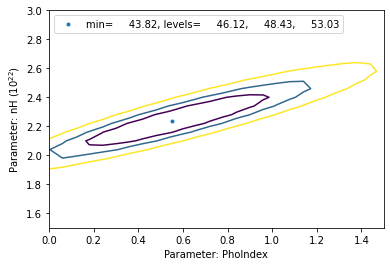

In [21]:
Plot.addCommand("image off")
Plot("contour")
Plot.delCommand(1)
labels = Plot.labels()
x = Plot.x()
y = Plot.y()
z = Plot.z()
levelvals = Plot.contourLevels()
statval = Fit.statistic
plt.contour(x,y,z,levelvals)
plt.ylabel(labels[0])
plt.xlabel(labels[1])
plt.errorbar(m1.phabs.nH.values[0],m1.powerlaw.PhoIndex.values[0],fmt='.')
legendstring = f"min={statval:{10}.{4}}, levels={levelvals[0]:{10}.{4}},{levelvals[1]:{10}.{4}},{levelvals[2]:{10}.{4}}"
plt.legend([legendstring], loc='upper left')

The contours shown are for one, two, and three sigma. The dot marks the best-fit position.

What else can we do with the fit? One thing is to derive the flux of the model. The data by themselves only give the instrument-dependent count rate. The model, on the other hand, is an estimate of the true spectrum emitted. In PyXspec, the model is defined in physical units independent of the instrument. AllModels.calcFlux() integrates the current model over the range specified by the user: 

In [22]:
AllModels.calcFlux("2.0 10.0")

 Model Flux 0.0035392 photons (2.2323e-11 ergs/cm^2/s) range (2.0000 - 10.000 keV)


AllModels is the way of operating on all Model objects in the same way as AllData on all Spectrum objects.

Here we have chosen the range of 2-10 keV and find that the energy flux is $2.2\times10^{-11}$ ergs/cm$^2$/s. Note that calcFlux will integrate only within the energy range of the current response matrix. If the model flux outside this range is desired - in effect, an extrapolation beyond the data - then the method setEnergies should be used. This method defines a set of energies on which the models will be calculated. The resulting models are then remapped onto the response energies for convolution with the response matrix. For example, if we want to know the flux of our model in the ROSAT PSPC band of 0.2-2 keV, we enter: 

In [23]:
AllModels.setEnergies("extend","low,0.2,100")
AllModels.calcFlux("0.2 2.0")


Models will use response energies extended to:
   Low:  0.2 in 100 log bins

Fit statistic  : Chi-Squared                   43.82     using 45 bins.

Test statistic : Chi-Squared                   43.82     using 45 bins.
 Null hypothesis probability of 3.94e-01 with 42 degrees of freedom
 Current data and model not fit yet.
 Model Flux  0.004288 photons (8.7862e-12 ergs/cm^2/s) range (0.20000 - 2.0000 keV)


The energy flux, at $8.8\times10^{-12}$ ergs/cm$^2$/s is lower in this band but the photon flux is higher. The model energies can be reset to the response energies using AllModels.setEnergies("reset"). Calculating the flux is not usually enough, we want its uncertainty as well. The best way to do this is to use the cflux model. Suppose further that what we really want is the flux without the absorption then we redefine the model by

In [24]:
parVals = m1(1).values[0], m1(2).values[0], m1(3).values[0]
m1 = Model("pha*cflux(pow)",setPars=(parVals[0],0.2,2.0,-10.3,parVals[1],parVals[2]))


Model phabs<1>*cflux<2>*powerlaw<3> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   cflux      Emin       keV      0.500000     frozen
   3    2   cflux      Emax       keV      10.0000      frozen
   4    2   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   5    3   powerlaw   PhoIndex            1.00000      +/-  0.0          
   6    3   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared                 3439.22     using 45 bins.

Test statistic : Chi-Squared                 3439.22     using 45 bins.
 Null hypothesis probability of 0.00e+00 with 41 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : Chi-Squared                   51.70     using 45 bins.

Test statistic : Chi-Squared                   51.70

The Emin and Emax parameters are set to the energy range over which we want the flux to be calculated. We also have to fix the norm of the powerlaw because the normalization of the model will now be determined by the lg10Flux parameter. 

In [25]:
m1.powerlaw.norm.frozen = True


Fit statistic  : Chi-Squared                   51.70     using 45 bins.

Test statistic : Chi-Squared                   51.70     using 45 bins.
 Null hypothesis probability of 1.45e-01 with 42 degrees of freedom
 Current data and model not fit yet.


In [26]:
Fit.perform()
Fit.error("4")

                                   Parameters
Chi-Squared  |beta|/N    Lvl          1:nH    4:lg10Flux    5:PhoIndex
43.821       153.637      -3      0.542833      -10.2824       2.23171
43.8179      2.64635      -4      0.550971      -10.2792       2.23570
 Variances and Principal Axes
                 1        4        5  
 3.3544E-05|  0.0629  -0.8010   0.5954  
 3.1521E-03|  0.5045  -0.4892  -0.7114  
 1.0233E-01|  0.8611   0.3451   0.3733  
----------------------------------------

  Covariance Matrix
        1           2           3   
   7.668e-02   2.963e-02   3.177e-02
   2.963e-02   1.296e-02   1.427e-02
   3.177e-02   1.427e-02   1.587e-02
------------------------------------

Model phabs<1>*cflux<2>*powerlaw<3> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    0.550971     +/-  0.276920     
   2    2   cflux      Emin       keV      0.200000     frozen
   3    2   cflux      Emax       keV    

for a 90% confidence range on the 0.2-2 keV unabsorbed flux of $3.49\times10^{-11}$ - $8.33\times10^{-11}$ ergs/cm$^2$/s.

The fit, as we've remarked, is good, and the parameters are constrained. But unless the purpose of our investigation is merely to measure a photon index, it's a good idea to check whether alternative models can fit the data just as well. We also should derive upper limits to components such as iron emission lines and additional continua, which, although not evident in the data nor required for a good fit, are nevertheless important to constrain. First, let's try an absorbed black body: 

In [27]:
m1 = Model("phabs*bb")
Fit.perform()


Model phabs<1>*bbody<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   bbody      kT         keV      3.00000      +/-  0.0          
   3    2   bbody      norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              3.379668e+09     using 45 bins.

Test statistic : Chi-Squared              3.379668e+09     using 45 bins.
 Null hypothesis probability of 0.000000e+00 with 42 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl          1:nH          2:kT        3:norm
1532.94      63.1918       0      0.332069       3.01550   0.000673517
1521.42      111571        0      0.153909       2.96509   0.000613317
1490.16      170627        0     0.0624033       2.87563   0.000569789
1

Note that the fit has written out a warning about the first parameter and its estimated error is written as -1. This indicates that the fit is unable to constrain the parameter and it should be considered indeterminate. This usually indicates that the model is not appropriate. One thing to check in this case is that the model component has any contribution within the energy range being calculated.

The black body fit is obviously not a good one. Not only is $\chi^2$ large, but the best-fitting N$_{\rm H}$ is indeterminate. Inspection of the residuals confirms this: the pronounced wave-like shape is indicative of a bad choice of overall continuum. 

In [28]:
Plot("data resid")
energies = Plot.x()
edeltas = Plot.xErr()
rates = Plot.y(1,1)
errors = Plot.yErr(1,1)
foldedmodel = Plot.model()
dataLabels = Plot.labels(1)
residLabels = Plot.labels(2)
# note that for matplotlib step plots we need an x-axis array which includes the start and end value for each
# bin and the y-axis has to be the same size with an extra value added equal to the value of the last bin
nE = len(energies)
stepenergies = list()
for i in range(nE):
    stepenergies.append(energies[i] - edeltas[i])
stepenergies.append(energies[-1]+edeltas[-1])
foldedmodel.append(foldedmodel[-1])
resid = Plot.y(1,2)
residerr = Plot.yErr(1,2)

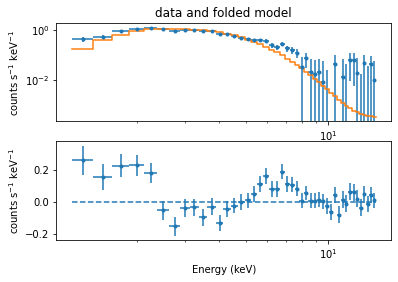

In [29]:
plt.subplot(211)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(dataLabels[1])
plt.title(dataLabels[2])
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.')
plt.step(stepenergies,foldedmodel,where='post')
plt.subplot(212)
plt.xscale('log')
plt.xlabel(residLabels[0])
plt.ylabel(residLabels[1])
plt.errorbar(energies,resid,xerr=edeltas,yerr=residerr,fmt='.')
plt.hlines(0.0,stepenergies[0],stepenergies[-1],linestyles='dashed')

Note the wave-like shape of the residuals which indicates how poor the fit is, i.e. that the continuum is obviously not a black body.

Let's try thermal bremsstrahlung next:

In [30]:
m1 = Model("phabs*br")
Fit.perform()


Model phabs<1>*bremss<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   bremss     kT         keV      7.00000      +/-  0.0          
   3    2   bremss     norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              4.561670e+07     using 45 bins.

Test statistic : Chi-Squared              4.561670e+07     using 45 bins.
 Null hypothesis probability of 0.000000e+00 with 42 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl          1:nH          2:kT        3:norm
102.905      23.3691      -3      0.274774       6.15759    0.00726465
46.547       16309.7      -4     0.0366323       5.60534    0.00785786
43.1796      5581.18      -5     0.0168094       5.64491    0.00792020


Bremsstrahlung is a better fit than the black body - and is as good as the power law - although it shares the low absorption column. With two good fits, the power law and the bremsstrahlung, it's time to scrutinize their parameters in more detail.

From the EXOSAT database on HEASARC, we know that the target in question, 1E1048.1-5937, is almost on the plane of the Galaxy. In fact, the database also provides the value of the Galactic N$_{\rm H}$ based on 21-cm radio observations. At $4\times10^{22}$ cm$^{-2}$, it is higher than the 90 percent-confidence upper limit from the power-law fit. Perhaps, then, the power-law fit is not so good after all. What we can do is fix (freeze in XSPEC terminology) the value of N$_{\rm H}$ at the Galactic value and refit the power law. Although we won't get a good fit, the shape of the residuals might give us a clue to what is missing.

In [31]:
m1 = Model("phabs*po")
m1.phabs.nH = 4.0
m1.phabs.nH.frozen = True
Fit.perform()


Model phabs<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   3    2   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              4.869991e+08     using 45 bins.

Test statistic : Chi-Squared              4.869991e+08     using 45 bins.
 Null hypothesis probability of 0.000000e+00 with 42 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : Chi-Squared              3.225015e+08     using 45 bins.

Test statistic : Chi-Squared              3.225015e+08     using 45 bins.
 Null hypothesis probability of 0.000000e+00 with 42 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : Chi-Squared              3.225015e+08     using 45 

In [32]:
Plot()
energies = Plot.x()
edeltas = Plot.xErr()
rates = Plot.y(1,1)
errors = Plot.yErr(1,1)
foldedmodel = Plot.model()
dataLabels = Plot.labels(1)
residLabels = Plot.labels(2)
# note that for matplotlib step plots we need an x-axis array which includes the start and end value for each
# bin and the y-axis has to be the same size with an extra value added equal to the value of the last bin
nE = len(energies)
stepenergies = list()
for i in range(nE):
    stepenergies.append(energies[i] - edeltas[i])
stepenergies.append(energies[-1]+edeltas[-1])
foldedmodel.append(foldedmodel[-1])
resid = Plot.y(1,2)
residerr = Plot.yErr(1,2)

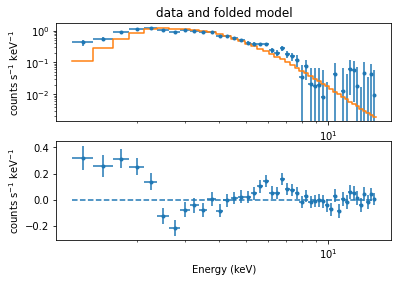

In [33]:
plt.subplot(211)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(dataLabels[1])
plt.title(dataLabels[2])
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.')
plt.step(stepenergies,foldedmodel,where='post')
plt.subplot(212)
plt.xscale('log')
plt.xlabel(residLabels[0])
plt.ylabel(residLabels[1])
plt.errorbar(energies,resid,xerr=edeltas,yerr=residerr,fmt='.')
plt.hlines(0.0,stepenergies[0],stepenergies[-1],linestyles='dashed')

There appears to be a surplus of softer photons, perhaps indicating a second continuum component. To investigate this possibility we can add a component to our model. Here, we'll add a black body component. Note that we freeze the temperature parameter of the black body to 2 keV(the canonical temperature for nuclear burning on the surface of a neutron star in a low-mass X-ray binary) using an xspec trick that setting the delta for a parameter to zero switches its freeze/thaw status. We also set the normalization of the component to a small number to start the fit off in a sensible place since we are looking for a small change to the model.

In [34]:
parVals = m1(1).values[0], m1(2).values[0], m1(3).values[0]
m1 = Model("phabs(pow+bb)",setPars=(parVals[0],parVals[1],parVals[2],"2.0,0.0",1.0e-5))
m1.phabs.nH.frozen = True


Model phabs<1>(powerlaw<2> + bbody<3>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   3    2   powerlaw   norm                1.00000      +/-  0.0          
   4    3   bbody      kT         keV      3.00000      +/-  0.0          
   5    3   bbody      norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              6.337778e+09     using 45 bins.

Test statistic : Chi-Squared              6.337778e+09     using 45 bins.
 Null hypothesis probability of 0.000000e+00 with 40 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : Chi-Squared                  128.71     using 45 bins.

Test statistic : Chi-Squared                  128.71     using 45 bins.
 Null hypothesis pro

In [35]:
Fit.perform()

                                   Parameters
Chi-Squared  |beta|/N    Lvl    2:PhoIndex        3:norm        5:norm
126.369      52634.5      -3       4.44901      0.191640   0.000242936
88.7273      6318.39      -4       4.83559      0.304037   0.000224283
68.4503      82867.1      -5       4.82979      0.334239   0.000227892
68.4497      514.395      -6       4.82939      0.333962   0.000227796
 Variances and Principal Axes
                 2        3        5  
 1.1806E-10| -0.0003   0.0008   1.0000  
 7.0700E-05|  0.2855  -0.9584   0.0009  
 2.7644E-02|  0.9584   0.2855   0.0001  
----------------------------------------

  Covariance Matrix
        1           2           3   
   2.540e-02   7.545e-03   2.570e-06
   7.545e-03   2.318e-03   7.020e-07
   2.570e-06   7.020e-07   4.273e-10
------------------------------------

Model phabs<1>(powerlaw<2> + bbody<3>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         

The fit is better than the one with just a power law and the fixed Galactic column, but it is still not good. Thawing the black body temperature and fitting does of course improve the fit but the powerl law index becomes even steeper. Looking at this odd model with the command 

In [36]:
Plot("model")
energies = Plot.x()
edeltas = Plot.xErr()
modelvals = Plot.model()
modelcomp1 = Plot.addComp(1)
modelcomp2 = Plot.addComp(2)
labels = Plot.labels()
nE = len(energies)
stepenergies = list()
for i in range(nE):
    stepenergies.append(energies[i] - edeltas[i])
stepenergies.append(energies[-1]+edeltas[-1])
modelvals.append(modelvals[-1])
modelcomp1.append(modelcomp1[-1])
modelcomp2.append(modelcomp2[-1])

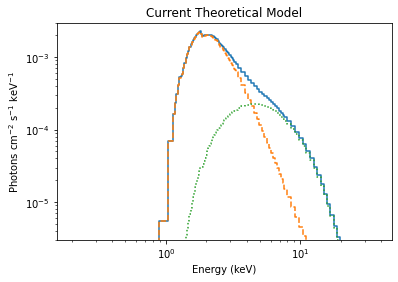

In [37]:
plt.xscale('log')
plt.yscale('log')
plt.ylim(3.0e-6,3.0e-3)
plt.title(labels[2])
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.step(stepenergies,modelvals,where='post')
plt.step(stepenergies,modelcomp1,where='post',linestyle='dashed')
plt.step(stepenergies,modelcomp2,where='post',linestyle='dotted')

 We see that the black body and the power law have changed places, in that the power law provides the soft photons required by the high absorption, while the black body provides the harder photons. We could continue to search for a plausible, well-fitting model, but the data, with their limited signal-to-noise and energy resolution, probably don't warrant it (the original investigators published only the power law fit).

There is, however, one final, useful thing to do with the data: derive an upper limit to the presence of a fluorescent iron emission line. We return to our original model and add a gaussian emission line of fixed energy and width then fit to get: 

In [38]:
m1 = Model("phabs*(po + ga)", setPars=(1.0,1.0,1.0,"6.4,0.0","0.1,0.0",1.0e-4))
Fit.perform()


Model phabs<1>(powerlaw<2> + gaussian<3>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   3    2   powerlaw   norm                1.00000      +/-  0.0          
   4    3   gaussian   LineE      keV      6.50000      +/-  0.0          
   5    3   gaussian   Sigma      keV      0.100000     +/-  0.0          
   6    3   gaussian   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              1.879034e+09     using 45 bins.

Test statistic : Chi-Squared              1.879034e+09     using 45 bins.
 Null hypothesis probability of 0.000000e+00 with 39 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : Chi-Squared              4.870628e+08     using 45 bins.

Test statist

The energy and width have to be frozen because, in the absence of an obvious line in the data, the fit would be completely unable to converge on meaningful values. Besides, our aim is to see how bright a line at 6.4 keV can be and still not ruin the fit. To do this, we fit first and then use the error command to derive the maximum allowable iron line normalization. We then set the normalization at this maximum value with and, finally, derive the equivalent width. That is: 

In [39]:
Fit.error("6")

***Warning: Parameter pegged at hard limit: 0


 Parameter   Confidence Range (2.706)
     6            0  0.000151075    (-7.46547e-05,7.64201e-05)


Note that the true minimum value of the gaussian normalization is less than zero, but the error search stopped when the minimum value hit zero, the "hard" lower limit of the parameter. 

In [40]:
m1.gaussian.norm = m1.gaussian.norm.error[1]


Fit statistic  : Chi-Squared                   46.06     using 45 bins.

Test statistic : Chi-Squared                   46.06     using 45 bins.
 Null hypothesis probability of 2.71e-01 with 41 degrees of freedom
 Current data and model not fit yet.


In [41]:
AllModels.eqwidth("3")


Data group number: 1
Additive group equiv width for Component 3:  0.782911 keV


The eqwidth method takes the component number as its argument.